# ECE 228 Final Project Deep Embedded Clustering
## By Heather Huntley, John O'boyle, Cameron Lewis

In this notebook we walk through the steps needed to perform deep embedded clustering on seismic data from the Ross ice shelf.

In [1]:
#these lines reload the libraries if any changes are made in the other files.
%reload_ext autoreload
%autoreload 2
#This notebook libraries
import numpy as np
from torchsummary import summary
from joblib import dump, load

#these libraries contain all of the important sections of code
from data import *
from train import *
from networks import *
from visualisation import *
from train_clust import *


#these are all for visualisation purposes
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cuml import TSNE

#the networks use double precision to avoid underflow issues
torch.set_default_dtype(torch.float64)

### Visualise the autoencoder architecture

In [33]:
temp = AEC()
temp.type(torch.float32)
temp.to(torch.device('cuda'))
summary(temp,(1,87,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 50]              80
              ReLU-2            [-1, 8, 44, 50]               0
            Conv2d-3           [-1, 16, 22, 25]           1,168
              ReLU-4           [-1, 16, 22, 25]               0
            Conv2d-5           [-1, 32, 11, 13]           4,640
              ReLU-6           [-1, 32, 11, 13]               0
            Conv2d-7             [-1, 64, 6, 7]          18,496
              ReLU-8             [-1, 64, 6, 7]               0
            Conv2d-9            [-1, 128, 3, 3]          73,856
             ReLU-10            [-1, 128, 3, 3]               0
          Flatten-11                 [-1, 1152]               0
           Linear-12                    [-1, 9]          10,377
             ReLU-13                    [-1, 9]               0
          Encoder-14                   

### Get the dataset

In [2]:
#This is the dataset of spectrograms
dataset = H5SeismicDataset(
    filepath="/datasets/ee228-sp21-A00-public/RIS_Seismic-001.h5",
    transform = transforms.Compose(
        [SpecgramShaper(), SpecgramToTensor()]
    )
)
#dataset[0] = train set
#dataset[1] = validation set
#dataset[2] = testing set
dataloaders = getDataloaderSplit(dataset, 0.2,0.1)

In [5]:
print(dataloaders[0].len)
print(dataloaders[1].len)
print(dataloaders[2].len)
print(len(dataset))

299460
85559
42779
427798


### Load the model or train the model
This section returns the trained autoencoder

In [35]:
#Use a saved model
USE_SAVED=True
if USE_SAVED:
    PATH='./saved_models/AEC/state_dict_AEC2.pt'
    model = AEC()
    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.double()
else:
    device = torch.device('cuda')
    model = AEC()
    model.to(device)
    params={'lr':.001,'epochs':10,}
    #outputs = pretrain(model= model,dataloaders=dataloaders,device=device,lr=params['lr'], epochs=params['epochs'], absoluteLossThresh = 0.0032)
    outputs = pretrain(model= model,dataloaders=dataloaders,device=device,lr=params['lr'], epochs=params['epochs'])
    model.eval()
    #visualise the results of training
    #get_graphs(outputs[0],outputs[1],'./saved_models/AEC/test_fig')
    #get_graphs(outputs[3],outputs[4],'./saved_models/AEC/loss_fig_iterations')

#### Visualize the Training of the Autoencoder

![./saved_models/AEC/Lr.001Epoch100.png](./saved_models/AEC/Lr.001Epoch100.png)

Note that the above training loss is over 100 epochs while we only ever train for 10. This is just to show that training for 10 epochs is more than enough.

### Get latent feature space
The following section runs the entire dataset through the model and saves the latent feature space representation of the dataset.

We save the train set as well as the test set.

In [15]:
model.to(torch.device('cuda'))
print("Z_array_train")
z_array_train = getLatentFeatureSpaceDataset(model, dataloaders[0], double=True)
print("Z_array_test")
z_array_test = getLatentFeatureSpaceDataset(model, dataloaders[2], double=True)

Z_array_train
Z_array_test


### Train the GMM clustering component of the DEC model
The following section trains a Gaussian Mixture Model on the training set

In [36]:
if USE_SAVED:
    model.gmm = load('./saved_models/AEC/modelGMMTrainSet.joblib') 
else:
    model.to(torch.device('cpu'))
    model = clustTrain(model,latentSpaceArray=z_array_train)

### Cluster the testign set and visualize the results

In [17]:
labels = model.gmm.predict(z_array_test)

In [18]:
tsne_Z = tsne(z_array_test)

Running t-SNE...complete.


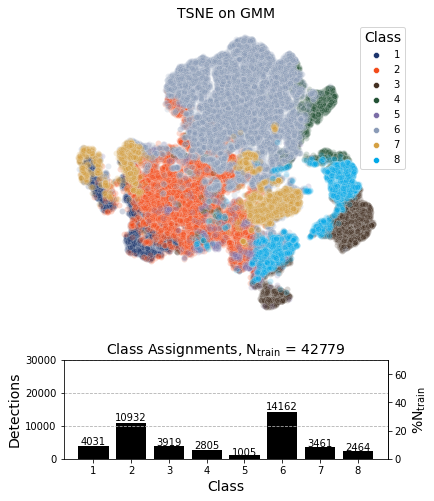

In [19]:
out = view_TSNE(tsne_Z,labels,"TSNE on GMM",True)

## TSNE Visualisation from saved model

![./saved_models/AEC/TSNEAEGraphDoublePrecTrainFullDataset.png](./saved_models/AEC/TSNEAEGraphDoublePrecTrainFullDataset.png)

### Save the model if needed

In [20]:
PATH='./saved_models/AEC/state_dict_AEC2.pt'
torch.save(model.state_dict(), PATH)
dump(model.gmm, './saved_models/AEC/modelGMMTrainSet.joblib') 